# A*Star BII programming interview

### Question 3

In [1]:
import os
import time
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from keras.layers import Dense, Input
from keras.models import Model, load_model
from keras.optimizers import Adam

Using TensorFlow backend.


In [0]:
X_train = pd.read_csv(os.path.join('train_data.txt'), sep='\t')
y_train = pd.read_csv(os.path.join('train_truth.txt'), sep='\t')

X_test = pd.read_csv(os.path.join('test_data.txt'), sep='\t')

### Linear Regression (Baseline)

In [0]:
lnr_model = LinearRegression()
lnr_model.fit(X_train, y_train)
y_pred = lnr_model.predict(X_train)

In [4]:
print(r2_score(y_train, y_pred))

0.9844447735791826


A linear regressino model obtains an $R^2$ value of 0.9844, which indicates near perfect linear relationship. Since we do not have the truth for the test dataset, we will use this simple metric to judge that the fit is good. We now would like to build a neural network that can match or surpass this performance.

### Multilayer Perceptron

In [0]:
# Helper function for neural network experimentation
def train_nn(x_train, y_train, input_layer, output_layer, 
             epochs, batch_size, lr, loss, metrics=None, 
             weights_file=None, history_file=None, reset=True):
    # Initialize model
    nn_model = Model(inputs=input_layer, outputs=output_layer)
    nn_model.summary()
    # Load weights
    if not reset and weights_file and os.path.isfile(weights_file):
        try:
            print('Weights loaded')
            nn_model.load_weights(weights_file)
        except:
            pass
    nn_model.compile(loss=loss, optimizer=Adam(lr=lr), metrics=metrics)
    # Train model
    start = time.time()
    history = nn_model.fit(x_train, y_train, epochs=epochs, 
                           batch_size=batch_size, validation_split=0.2)
    end = time.time()
    print(end-start, 'secs')
    # Add learning curve of current training session to history
    if not reset and os.path.isfile(history_file):
        with open(history_file, 'rb') as rf:
            total_history = pickle.load(rf)
    else:
        total_history = None
    if total_history:
        for key in total_history.keys():
            total_history[key] += history.history[key]
    else:
        total_history = history.history
    # Save model
    if weights_file:
        nn_model.save_weights(weights_file)
    if history_file:
        pickle.dump(total_history, open(history_file, 'wb'))
    return nn_model, total_history

In [6]:
# Define Neural Network
mlp_in = Input(shape=X_train.shape[1:])
mlp_1 = Dense(units=8, activation='relu', kernel_regularizer=None)(mlp_in)
mlp_out = Dense(units=1)(mlp_1)

# Train Neural Network
mlp_results = train_nn(x_train=X_train, y_train=y_train, 
                       input_layer=mlp_in, output_layer=mlp_out, 
                       epochs=2**9, batch_size=2**9, lr=1e-3, 
                       loss='mean_squared_error', 
                       weights_file='mlp_weights.h5', 
                       history_file='mlp_history.pkl', 
                       reset=True)
mlp_model, mlp_history = mlp_results

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 32        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 9         
Total params: 41
Trainable params: 41
Non-trainable params: 0
_________________________________________________________________
Train on 8000 samples, validate on 2000 samples
Epoch 1/512
8000/8000 [==============================] - 0s 37us/step - loss: 0.2042 - val_loss: 0.1664
Epoch 2/512
8000/8000 [==============================] - 0s 4us/step - loss: 0.1346 - val_loss: 0.1080
Epoch 3/512
8000/8000 [==============================] - 0s 4us/step - loss: 0.0870 - val_loss: 0.0705
Epoch 4/512
8000/8000 [============

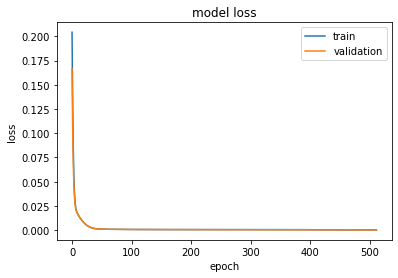

In [7]:
plt.plot(mlp_history['loss'])
plt.plot(mlp_history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')

In [ ]:
# Write output prediction
y_test_pred = mlp_model.predict(X_test)
pd.DataFrame({'y':y_test_pred[:, 0]}).to_csv('test_predicted')

In [8]:
y_pred = mlp_model.predict(X_train)
print(r2_score(y_train, y_pred))

0.9935485578218093


The multilayer perceptron obtains an $R^2$ of 0.9935 which is higher than that obtained by the linear regression model. This is a promising result.

Based on the learning curve, there is no evidence of over-fitting, so we can expect the model to work well for unseen data.